## Imports 

In [1]:
import matplotlib.pyplot as plt
import numpy as np
import pandas as pd
from sklearn.compose import ColumnTransformer, make_column_transformer
from sklearn.dummy import DummyClassifier
from sklearn.impute import SimpleImputer
from sklearn.model_selection import cross_val_score, cross_validate, train_test_split
from sklearn.neighbors import KNeighborsClassifier
from sklearn.pipeline import Pipeline, make_pipeline
from sklearn.preprocessing import OneHotEncoder, StandardScaler, OrdinalEncoder
from sklearn.svm import SVC
from sklearn.tree import DecisionTreeClassifier

## EDA

We will be using [the adult census dataset](https://www.kaggle.com/uciml/adult-census-income#) from Kaggle ("adult.csv" in this repository). This is a classification dataset with the task of predicting whether income exceeds 50K per year given the census data. You can find more information on the dataset and features [here](http://archive.ics.uci.edu/ml/datasets/Adult).

In [2]:
census_df = pd.read_csv("adult.csv")
census_df.shape

(32561, 15)

### 1.1 Data splitting 

We will split the data into `train_df` (60%) and `test_df` (40%) with a fixed `random_state` so that results are consistent between users. The training set is somewhat small because it's a large dataset and my laptop is not that powerful.

In [3]:
train_df, test_df = train_test_split(census_df, test_size = 0.4, random_state = 42)

<br><br>

Let's examine our `train_df`. 

In [4]:
train_df.sort_index()

age workclass  fnlwgt     education  education.num      marital.status  \
0       90         ?   77053       HS-grad              9             Widowed   
1       82   Private  132870       HS-grad              9             Widowed   
2       66         ?  186061  Some-college             10             Widowed   
5       34   Private  216864       HS-grad              9            Divorced   
9       41   Private   70037  Some-college             10       Never-married   
...    ...       ...     ...           ...            ...                 ...   
32553   43   Private   84661     Assoc-voc             11  Married-civ-spouse   
32554   32   Private  116138       Masters             14       Never-married   
32555   53   Private  321865       Masters             14  Married-civ-spouse   
32557   27   Private  257302    Assoc-acdm             12  Married-civ-spouse   
32559   58   Private  151910       HS-grad              9             Widowed   

            occupation   relationship                race     sex  \
0                    ?  Not-in-family               White  Female   
1      Exec-managerial  Not-in-family               White  Female   
2                    ?      Unmarried               Black  Female   
5        Other-service      Unmarried               White  Female   
9         Craft-repair      Unmarried               White    Male   
...                ...            ...                 ...     ...   
32553            Sales        Husband               White    Male   
32554     Tech-support  Not-in-family  Asian-Pac-Islander    Male   
32555  Exec-managerial        Husband               White    Male   
32557     Tech-support           Wife               White  Female   
32559     Adm-clerical      Unmarried               White  Female   

       capital.gain  capital.loss  hours.per.week native.country income  
0                 0          4356              40  United-States  <=50K  
1                 0          4356              18  United-States  <=50K  
2                 0          4356              40  United-States  <=50K  
5                 0          3770              45  United-States  <=50K  
9                 0          3004              60              ?   >50K  
...             ...           ...             ...            ...    ...  
32553             0             0              45  United-States  <=50K  
32554             0             0              11         Taiwan  <=50K  
32555             0             0              40  United-States   >50K  
32557             0             0              38  United-States  <=50K  
32559             0             0              40  United-States  <=50K  

[19536 rows x 15 columns]

We see some missing values represented with a "?". Probably these were the questions not answered by some people during the census. We will replace them with `np.nan` before carrying on.

In [5]:
train_df_nan = train_df.replace("?", np.nan)
test_df_nan = test_df.replace("?", np.nan)
train_df_nan.shape

(19536, 15)

In [6]:
train_df_nan.sort_index()

age workclass  fnlwgt     education  education.num      marital.status  \
0       90       NaN   77053       HS-grad              9             Widowed   
1       82   Private  132870       HS-grad              9             Widowed   
2       66       NaN  186061  Some-college             10             Widowed   
5       34   Private  216864       HS-grad              9            Divorced   
9       41   Private   70037  Some-college             10       Never-married   
...    ...       ...     ...           ...            ...                 ...   
32553   43   Private   84661     Assoc-voc             11  Married-civ-spouse   
32554   32   Private  116138       Masters             14       Never-married   
32555   53   Private  321865       Masters             14  Married-civ-spouse   
32557   27   Private  257302    Assoc-acdm             12  Married-civ-spouse   
32559   58   Private  151910       HS-grad              9             Widowed   

            occupation   relationship                race     sex  \
0                  NaN  Not-in-family               White  Female   
1      Exec-managerial  Not-in-family               White  Female   
2                  NaN      Unmarried               Black  Female   
5        Other-service      Unmarried               White  Female   
9         Craft-repair      Unmarried               White    Male   
...                ...            ...                 ...     ...   
32553            Sales        Husband               White    Male   
32554     Tech-support  Not-in-family  Asian-Pac-Islander    Male   
32555  Exec-managerial        Husband               White    Male   
32557     Tech-support           Wife               White  Female   
32559     Adm-clerical      Unmarried               White  Female   

       capital.gain  capital.loss  hours.per.week native.country income  
0                 0          4356              40  United-States  <=50K  
1                 0          4356              18  United-States  <=50K  
2                 0          4356              40  United-States  <=50K  
5                 0          3770              45  United-States  <=50K  
9                 0          3004              60            NaN   >50K  
...             ...           ...             ...            ...    ...  
32553             0             0              45  United-States  <=50K  
32554             0             0              11         Taiwan  <=50K  
32555             0             0              40  United-States   >50K  
32557             0             0              38  United-States  <=50K  
32559             0             0              40  United-States  <=50K  

[19536 rows x 15 columns]

The "?" symbols are now replaced with NaN values. 

<br><br>

### 2.1 Visualizing features

Let's investigate some basic summary statistics of all the features, and visualize the histograms of numeric features. From the visualizations, we should be able to predict which features seem relevant for the classification task.

In [7]:
train_df_nan.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 19536 entries, 25823 to 23654
Data columns (total 15 columns):
 #   Column          Non-Null Count  Dtype 
---  ------          --------------  ----- 
 0   age             19536 non-null  int64 
 1   workclass       18428 non-null  object
 2   fnlwgt          19536 non-null  int64 
 3   education       19536 non-null  object
 4   education.num   19536 non-null  int64 
 5   marital.status  19536 non-null  object
 6   occupation      18424 non-null  object
 7   relationship    19536 non-null  object
 8   race            19536 non-null  object
 9   sex             19536 non-null  object
 10  capital.gain    19536 non-null  int64 
 11  capital.loss    19536 non-null  int64 
 12  hours.per.week  19536 non-null  int64 
 13  native.country  19187 non-null  object
 14  income          19536 non-null  object
dtypes: int64(6), object(9)
memory usage: 2.4+ MB


In [10]:
train_df_nan.describe(include="all")

age workclass        fnlwgt education  education.num  \
count   19536.000000     18428  1.953600e+04     19536   19536.000000   
unique           NaN         8           NaN        16            NaN   
top              NaN   Private           NaN   HS-grad            NaN   
freq             NaN     13570           NaN      6256            NaN   
mean       38.592547       NaN  1.892662e+05       NaN      10.084767   
std        13.638971       NaN  1.049020e+05       NaN       2.580723   
min        17.000000       NaN  1.228500e+04       NaN       1.000000   
25%        28.000000       NaN  1.177670e+05       NaN       9.000000   
50%        37.000000       NaN  1.782835e+05       NaN      10.000000   
75%        47.000000       NaN  2.368860e+05       NaN      12.000000   
max        90.000000       NaN  1.455435e+06       NaN      16.000000   

            marital.status      occupation relationship   race    sex  \
count                19536           18424        19536  19536  19536   
unique                   7              14            6      5      2   
top     Married-civ-spouse  Prof-specialty      Husband  White   Male   
freq                  9025            2490         7937  16676  13079   
mean                   NaN             NaN          NaN    NaN    NaN   
std                    NaN             NaN          NaN    NaN    NaN   
min                    NaN             NaN          NaN    NaN    NaN   
25%                    NaN             NaN          NaN    NaN    NaN   
50%                    NaN             NaN          NaN    NaN    NaN   
75%                    NaN             NaN          NaN    NaN    NaN   
max                    NaN             NaN          NaN    NaN    NaN   

        capital.gain  capital.loss  hours.per.week native.country income  
count   19536.000000  19536.000000    19536.000000          19187  19536  
unique           NaN           NaN             NaN             41      2  
top              NaN           NaN             NaN  United-States  <=50K  
freq             NaN           NaN             NaN          17517  14841  
mean     1090.443540     86.537162       40.532606            NaN    NaN  
std      7449.700833    402.395668       12.406636            NaN    NaN  
min         0.000000      0.000000        1.000000            NaN    NaN  
25%         0.000000      0.000000       40.000000            NaN    NaN  
50%         0.000000      0.000000       40.000000            NaN    NaN  
75%         0.000000      0.000000       45.000000            NaN    NaN  
max     99999.000000   4356.000000       99.000000            NaN    NaN

In [11]:
numeric_features = ["age", "fnlwgt", "education.num", "capital.gain", "capital.loss", "hours.per.week"]

In [12]:
X_pos = train_df_nan[train_df_nan.income == '<=50K']
X_neg = train_df_nan[train_df_nan.income == '>50K']

# Check that we got all the values
assert(X_pos.shape[0] + X_neg.shape[0] == train_df_nan.shape[0]) 

In [13]:
X_feat_pos = np.zeros([X_pos.shape[0], len(numeric_features)])
X_feat_neg = np.zeros([X_neg.shape[0], len(numeric_features)])

for j, feat in enumerate(numeric_features):
    
    X_feat_pos[:,j] = [X_pos[[feat]].iloc[i][0] for i in range(X_pos.shape[0])]
    X_feat_neg[:,j] = [X_neg[[feat]].iloc[i][0] for i in range(X_neg.shape[0])]

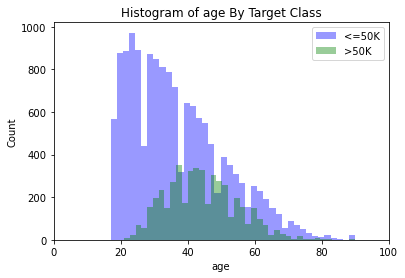

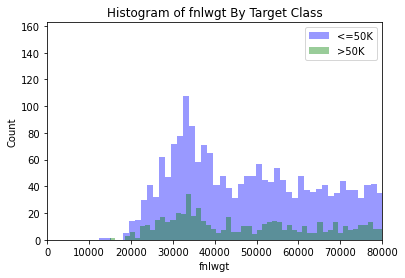

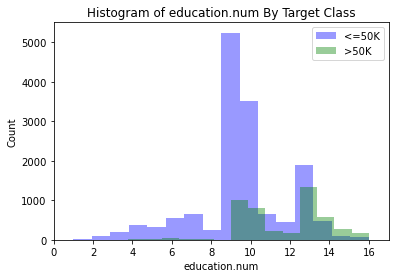

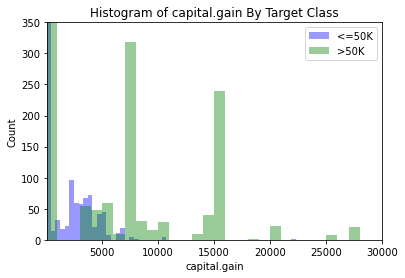

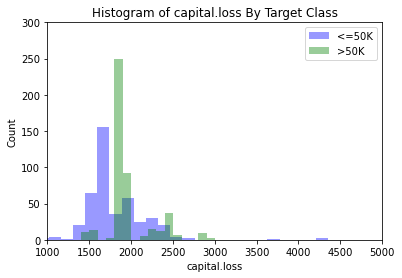

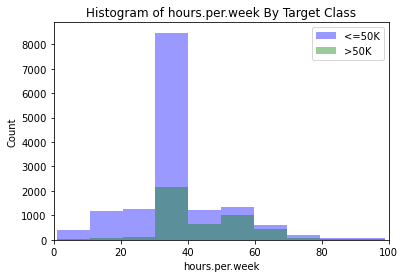

In [14]:
#Did this part in a separate loop so I could adjust
#the number of bins and x-limits in each plot without having
#to recalculate everything

bin_num = [40,1000,16,100,30,10]

#this gets rid of some of the extreme values of the data but those are rare
#and just make the plots harder to visualize properly
x_limit = [[0,100], [0,80000], [0,17], [100,30000], [1000,5000], [0,100]] 
y_limit = [None, None, None, [0,350], [0,300], None]

for j, feat in enumerate(numeric_features):
    
    plt.figure()
    plt.hist(X_feat_pos[:,j], bins = bin_num[j], color = "b", alpha = 0.4, label = "<=50K")
    plt.hist(X_feat_neg[:,j], bins = bin_num[j], color = "g", alpha = 0.4, label = ">50K")
    plt.xlabel(feat)
    plt.ylabel("Count")
    plt.title("Histogram of %s By Target Class" %feat)
    plt.xlim(x_limit[j])
    plt.ylim(y_limit[j])
    plt.legend()
    
plt.show()

<br><br>

<b>Comments:</b>

Important note: I decided to get rid of the $0 bins for capital gains and losses. Both <=50K and >50K earners were so plentiful in this box that it made it impossible to see the distribution of people who had a nonzero gain or loss.

Based on the histograms above, it seems that age would be the best feature for our task of classifying whether a person makes over $50k per year. This is because the distributions are obviously different (younger people tend to be paid less), and thus there is information from this feature which can be used in making our predictions.

There might also be some useful information in capital gains/losses. It looks like people who earn >50K tend to both gain more and lose more. This makes intuitive sense; people with higher salaries will have more money to invest in the stock market. 

In addition, in the hours per week plot, while both histograms may look somewhat similar, upon observation we see that the vast majority of people who make under 50k work 35-40 hours per week, while in the groups of >$50K earners, a larger proportion of them work over 40 hours per week (in other words, the green distribution is flatter while the blue one is sharper). 

Similarly, the education plot shows a sharper spike in the 9-11 range for the under 50K earners than the over 50K earners, and the the 13 bin shows a larger spike (relative to the rest of the distribution) for hte >50K earners than the <=50K earners.

### Transformations

In [18]:
#Used these few two cells to investigate each of the features.
train_df_nan[["capital.loss"]].describe(include="all")

capital.loss
count  19536.000000
mean      86.537162
std      402.395668
min        0.000000
25%        0.000000
50%        0.000000
75%        0.000000
max     4356.000000

In [19]:
train_df_nan[["capital.loss"]]

capital.loss
25823             0
10274             0
27652             0
13941             0
31384             0
...             ...
29802             0
5390              0
860            1887
15795             0
23654             0

[19536 rows x 1 columns]

In [20]:
train_df_nan[["native.country"]].info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 19536 entries, 25823 to 23654
Data columns (total 1 columns):
 #   Column          Non-Null Count  Dtype 
---  ------          --------------  ----- 
 0   native.country  19187 non-null  object
dtypes: object(1)
memory usage: 305.2+ KB


| Feature | Transformation |
| --- | ----------- |
| occupation | Imputation, OHE |
| age | Scaling |
| workclass | Imputation, OHE |
| fnlwgt | Scaling |
| education | OHE |
| education.num | Scaling |
| marital.status | OHE |
| relationship | OHE |
| race | OHE |
| sex | OHE |
| capital.gain | Scaling |
| capital.loss | Scaling |
| hours.per.week | Scaling |
| native.country | Imputation, OHE |


In [21]:
numeric_features = ["age", "fnlwgt", "education.num", "hours.per.week"]
categorical_features = ["occupation", "workclass", "education", "marital.status", 
                       "relationship", "race", "native.country"]#I was going to make education ordinal, but it's not clear how to order masters/doctorate vs. prof school

binary_features = ["sex"] #This is biological sex (not gender) and as the data is presented it is binary
drop_features = [] #I would consider dropping "occupation" if there were approximately n unique values, but there are only 14.
impute_features = ["occupation", "workclass", "native.country"]
passthrough_features = ["capital.gain", "capital.loss"] #These are sparse features
target = "income"

<b>Remark on ethics:</b> I do not think that investigating any statistic is inherently ethically wrong. For example, in my opinion it would be okay for a researcher in the social sciences to investigate whether there exists a correlation between race and salary. However, if you knew this model was going to be used by a company to aid in determining whether or not to approve a loan, the model should be fairly explainable and that sort of decision should be based purely on financial features (not on race/gender/etc). 

<br><br>

### Separating feature vectors and targets  

In [22]:
X_train = train_df_nan.drop(["income"], axis=1)
X_test = test_df_nan.drop(["income"], axis=1)
y_train = train_df_nan[["income"]]
y_test = test_df_nan[["income"]]

<br><br>

## Preprocessing 

### Preprocessing

Let's carry out preprocessing using `sklearn`'s `ColumnTransformer` and `Pipeline`.

In [23]:
imp_ohe_pipeline = make_pipeline(SimpleImputer(missing_values=np.nan, strategy="most_frequent"),
                                OneHotEncoder(handle_unknown="ignore", dtype=int))

In [24]:
preprocessor = make_column_transformer(
    (imp_ohe_pipeline, categorical_features+impute_features), #doesn't hurt to impute features that don't necessarily need it
    (StandardScaler(), numeric_features)
)

In [25]:
X_train_trans = preprocessor.fit_transform(X_train)
X_train_trans = pd.DataFrame(X_train_trans.toarray())
print("The shape of the data is:")
X_train_trans.shape

The shape of the data is:


(19536, 164)

The number of features has increased from 14 to 164. This comes from the encoding. Every categorical features with $m$ categories has been turned into $m$ distinct features. Note that we needed to use a column transformer because each column needs a unique treatment. If we simply used a pipeline, we'd be using the wrong transformers on certain columns (for example, OHE on data that's already numerical, or scaling on non-numerical data).

<br><br>

## Building models

In [26]:
results_dict = {} # dictionary to store all the results

In [27]:
def mean_std_cross_val_scores(model, X_train, y_train, **kwargs):
    """
    Returns mean and std of cross validation

    Parameters
    ----------
    model :
        scikit-learn model
    X_train : numpy array or pandas DataFrame
        X in the training data
    y_train :
        y in the training data

    Returns
    ----------
        pandas Series with mean scores from cross_validation
    """

    scores = cross_validate(model, X_train, y_train, **kwargs)

    mean_scores = pd.DataFrame(scores).mean()
    std_scores = pd.DataFrame(scores).std()
    out_col = []

    for i in range(len(mean_scores)):
        out_col.append((f"%0.3f (+/- %0.3f)" % (mean_scores[i], std_scores[i])))

    return pd.Series(data=out_col, index=mean_scores.index)

<br><br>

### 4.1 Baseline model 

We will use `scikit-learn`'s `DummyClassifier` with `strategy="prior"` as our baseline model, against which our actual models will be compared.

In [28]:
dc = DummyClassifier(strategy = "prior")

pipe = make_pipeline(preprocessor, dc)

results_dict["dummy"] = mean_std_cross_val_scores(pipe, X_train, y_train, cv=5)

dummy_cv = pd.DataFrame(results_dict["dummy"], columns = ["DummyClassifier"])
dummy_cv

DummyClassifier
fit_time    0.083 (+/- 0.005)
score_time  0.027 (+/- 0.008)
test_score  0.760 (+/- 0.000)

The dummy classifier actually does fairly well, and this is just because the majority of people in the dataset make under \$50K.

<br><br>

### Trying Different Classifiers

In [29]:
models = {
    "Decision Tree": DecisionTreeClassifier(),
    "kNN": KNeighborsClassifier(),
    "RBF SVM": SVC(),
}

for model_name in list(models.keys()):
    
    pipe = make_pipeline(preprocessor, models[model_name])
    
    results_dict[model_name] = mean_std_cross_val_scores(pipe, X_train, np.ravel(y_train), cv=5)

In [30]:
result_df = pd.DataFrame()
for model_name in list(models.keys()):
    result_df[model_name] = results_dict[model_name]
    
result_df

Decision Tree                kNN             RBF SVM
fit_time    0.639 (+/- 0.024)  0.097 (+/- 0.018)  11.723 (+/- 0.689)
score_time  0.031 (+/- 0.010)  4.163 (+/- 0.330)   1.468 (+/- 0.108)
test_score  0.779 (+/- 0.002)  0.822 (+/- 0.006)   0.836 (+/- 0.005)

The overall fastest model is the decision tree. kNN is quite fast during fit (since it's not really doing anything during fit except storing the data), and slower during prediction (since this is where it computes all the distances). For the SVM, once we have the support vectors, this saves massive amounts of time during the predict phase.

As for accuracy, the decision tree is not much better than the dummy classifier. On the other hand kNN performs better, and as expected, SVM performs even better still. Of course, this is just with the default settings on each model, and no hyperparameter tuning.

<br><br>

### 4.4 Hyperparameter optimization

Let's carry out hyperparameter optimization for the hyperparameter `C` of SVC RBF classifier. 

In [31]:
#Quite slow, so I am not checking many parameters, but in a real setting obviously
#one would want to optimize over a much denser grid and also over various kernels.
param_grid = {"C": np.logspace(-2, 2, 4)}

In [32]:
for c in param_grid["C"]:
    
    pipe = make_pipeline(preprocessor, SVC(C=c))
    
    results_dict["SVM (C=%.3f)"%(c)] = mean_std_cross_val_scores(pipe, X_train, np.ravel(y_train), cv=5)

In [33]:
SVM_result_df = pd.DataFrame()
for c in param_grid["C"]:
    SVM_result_df["SVM (C=%.3f)"%(c)] = results_dict["SVM (C=%.3f)"%(c)]
    
SVM_result_df

SVM (C=0.010)       SVM (C=0.215)       SVM (C=4.642)  \
fit_time    12.069 (+/- 0.989)  11.053 (+/- 0.674)  14.522 (+/- 1.335)   
score_time   1.807 (+/- 0.273)   1.455 (+/- 0.116)   1.470 (+/- 0.213)   
test_score   0.821 (+/- 0.005)   0.833 (+/- 0.004)   0.838 (+/- 0.004)   

               SVM (C=100.000)  
fit_time    34.744 (+/- 2.946)  
score_time   1.410 (+/- 0.094)  
test_score   0.814 (+/- 0.006)

The hyperparameter which seems to be performing best is $C=4.64$. It has better accuracy than the default value of $C=1$ as we saw in question 4.2, and the standard deviation of the accuracy does not change by much.

<br><br>

## Evaluating on the test set 

Now that we have a best performing model, we can check the performance on the test set.

In [34]:
C_best = param_grid["C"][2]

sv = SVC(C=C_best)

pipe = make_pipeline(preprocessor, sv)
pipe.fit(X_train, np.ravel(y_train));

In [35]:
accuracy = pipe.score(X_test, y_test)

In [36]:
print("Using C = %.3f, the test score of SVM is %.3f, while the cross-validation score was %s" %(C_best,accuracy,SVM_result_df.iloc[2][2]))

Using C = 4.642, the test score of SVM is 0.834, while the cross-validation score was 0.838 (+/- 0.004)


<br><b>Remark:</b> The cross validation accuracy is very similar to the test accuracy, which is very good as it indicates our approximation error is quite low. 